In [2]:
%matplotlib inline
from config_calc import *
import grid_tools

import cesm_orcas_sci as cesm
import cam
import gv

import colorbrewer

import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/Users/mclong/Dropbox/miniconda2/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
case = 'bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004a'
obs,mdl = gv.open_flightdata(case,mask=True)
mdl.info()

xarray.Dataset {
dimensions:
	time = 34205 ;

variables:
	float64 O2_OCN(time) ;
		O2_OCN:units = per meg ;
		O2_OCN:long_name = O2_OCN ;
	float64 CO2_T09k(time) ;
		CO2_T09k:units = ppmv ;
		CO2_T09k:long_name = Takahashi (Dec x -150%) ;
	float64 aO2_GKA(time) ;
		aO2_GKA:units = per meg ;
		aO2_GKA:long_name = GK2001 (abiotic) ;
	float64 CO2_C15O(time) ;
		CO2_C15O:units = ppmv ;
		CO2_C15O:long_name = CT2015 (ocean) ;
	float64 CO2_LND(time) ;
		CO2_LND:units = ppmv ;
		CO2_LND:long_name = CO2_LND ;
	float64 U10(time) ;
		U10:units = m/s ;
		U10:long_name = 10m wind speed ;
		U10:cell_methods = time: mean ;
	float64 CO2_T09(time) ;
		CO2_T09:units = ppmv ;
		CO2_T09:long_name = Takahashi (2009) ;
	float64 PS(time) ;
		PS:units = hPa ;
		PS:long_name = Surface pressure ;
		PS:cell_methods = time: mean ;
	float64 CO2_T09b(time) ;
		CO2_T09b:units = ppmv ;
		CO2_T09b:long_name = Takahashi (Jan x +50%) ;
	float64 CO2_T09c(time) ;
		CO2_T09c:units = ppmv ;
		CO2_T09c:long_name = Takahashi

In [7]:
%%time
alt_bins = np.concatenate((np.arange(0.,1.,0.25),np.arange(1.,14.5,0.5)))
alt_bin_c = np.vstack((alt_bins[0:-1],alt_bins[1:])).mean(axis=0)

groups = mdl.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
mdl_avg = groups.mean()
mdl_std = groups.std()

groups = obs.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
obs_avg = groups.mean()
obs_std = groups.std()
  
mdl_avg.info()

xarray.Dataset {
dimensions:
	GGALT_bins = 30 ;

variables:
	float64 GGALT_bins(GGALT_bins) ;
	float64 O2_OCN(GGALT_bins) ;
	float64 CO2_T09k(GGALT_bins) ;
	float64 aO2_GKA(GGALT_bins) ;
	float64 CO2_C15O(GGALT_bins) ;
	float64 CO2_LND(GGALT_bins) ;
	float64 U10(GGALT_bins) ;
	float64 CO2_T09(GGALT_bins) ;
	float64 PS(GGALT_bins) ;
	float64 CO2_T09b(GGALT_bins) ;
	float64 CO2_T09c(GGALT_bins) ;
	float64 CO2_T09d(GGALT_bins) ;
	float64 CO2_T09e(GGALT_bins) ;
	float64 CO2_T09f(GGALT_bins) ;
	float64 CO2_T09g(GGALT_bins) ;
	float64 CO2_T09h(GGALT_bins) ;
	float64 CO2_T09i(GGALT_bins) ;
	float64 CO2_T09j(GGALT_bins) ;
	float64 CO2_CROF(GGALT_bins) ;
	float64 CO2_T09l(GGALT_bins) ;
	float64 CO2_OCN(GGALT_bins) ;
	float64 CO2_CROT(GGALT_bins) ;
	float64 Pm(GGALT_bins) ;
	float64 OMEGA(GGALT_bins) ;
	float64 CO2_L14C(GGALT_bins) ;
	float64 Z3(GGALT_bins) ;
	float64 PBLH(GGALT_bins) ;
	float64 CO2_T09a(GGALT_bins) ;
	float64 CO2_CROO(GGALT_bins) ;
	float64 Q(GGALT_bins) ;
	float64 U(GGALT_bins

### Where is air coming from and how long did it take to get there?

Age of air tracer.  I screwed up the boundary conditions for the regional age tracers in `bgeos5.B20TRC5CN.f09_g16.BPRD_orcas_sci.004`.  These should sum to the total age, but rather than specifying a surface boundary condition of 0, I mistakenely specified a within-region boundary condition of 1, and 0 out of the region.  Thus, it is possible to reconstruct total age + 1, but the regional age tracers are hard to interpret individually.

The total age (`IDL_T000`, $A$) should be the sum of the regional age tracers (`IDL_T00N`, $\phi$):

$A = \sum \phi$

and the regional age ($A_i$) should be the regional age tracer divided by the regional provenance fraction (`IDL_S00N`):

$A_i = \frac{\phi}{f_i}$

Demonstrate the consistency with total and regional summed age below.

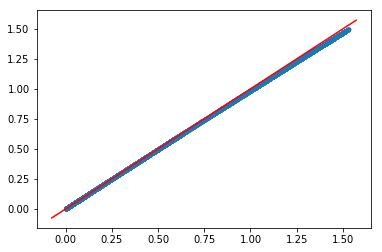

In [47]:
sage = xr.full_like(mdl.IDL_T000,fill_value=0.)
sfrac = xr.full_like(mdl.IDL_T000,fill_value=0.)
for i in range(1,7):
    fraci = mdl['IDL_S{:03d}'.format(i)]
    agei = mdl['IDL_T{:03d}'.format(i)]
    sfrac += fraci
    sage += agei
    
plt.plot(mdl.IDL_T000,sage,'.')
ylm = plt.gca().get_ylim()
plt.plot(ylm,ylm,'r-')

In [8]:
for v in sorted(mdl.variables):
    if 'IDL' in v:
        print('{sname}: {long_name}'.format(sname=v,long_name=mdl[v].attrs['long_name']))

IDL_S001: Land (except Antarctic)
IDL_S002: Anarctica
IDL_S003: Ocean 90N-30S
IDL_S004: Ocean 30S-45S
IDL_S005: Ocean 45S-60S
IDL_S006: Ocean 60S-90S
IDL_T000: Age of air
IDL_T001: Age of air (Land, except Antarctic)
IDL_T002: Age of air (Anarctica)
IDL_T003: Age of air (Ocean 90N-30S)
IDL_T004: Age of air (Ocean 30S-45S)
IDL_T005: Age of air (Ocean 45S-60S)
IDL_T006: Age of air (Ocean 60S-90S)


Aggregate some of these tracers into a smaller set of regions

In [60]:
#-- southern ocean (S of 45S) plus antarctica
regions = {'s_ocn':[2,5,6],
          'nh_ocn':[3,4],
          'land':[1]}

frac = xr.Dataset({'GGALT':mdl.GGALT})
age = xr.Dataset({'GGALT':mdl.GGALT})
for v,rlist in regions.items():
    frac[v] = np.sum(mdl['IDL_S%03d'%i] for i in rlist)
    age[v] = 365. * np.sum(mdl['IDL_T%03d'%i] for i in rlist) / np.sum(mdl['IDL_S%03d'%i] for i in rlist)

age['total'] = mdl.IDL_T000    

groups = age.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
age_avg = groups.mean()
age_std = groups.std()

groups = frac.groupby_bins('GGALT',alt_bins,labels=alt_bin_c)
frac_avg = groups.mean()
frac_std = groups.std()

age_avg

<xarray.Dataset>
Dimensions:     (GGALT_bins: 30)
Coordinates:
  * GGALT_bins  (GGALT_bins) float64 0.125 0.375 0.625 0.875 1.25 1.75 2.25 ...
Data variables:
    GGALT       (GGALT_bins) float64 dask.array<shape=(30,), chunksize=(28,)>
    land        (GGALT_bins) float64 dask.array<shape=(30,), chunksize=(28,)>
    nh_ocn      (GGALT_bins) float64 dask.array<shape=(30,), chunksize=(28,)>
    s_ocn       (GGALT_bins) float64 dask.array<shape=(30,), chunksize=(28,)>
    total       (GGALT_bins) float64 dask.array<shape=(30,), chunksize=(28,)>

demonstrate that we can reconstruct the total age

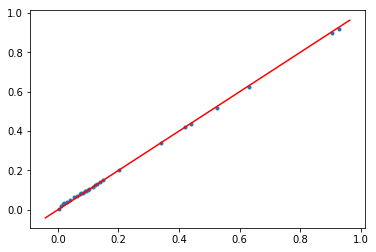

In [57]:
age_total_recon = np.sum(age_avg[v]*frac_avg[v] for v in ['s_ocn','nh_ocn','land'])
plt.plot(age_avg['total'],age_total_recon,'.')
ylm = plt.gca().get_ylim()
plt.plot(ylm,ylm,'r-')

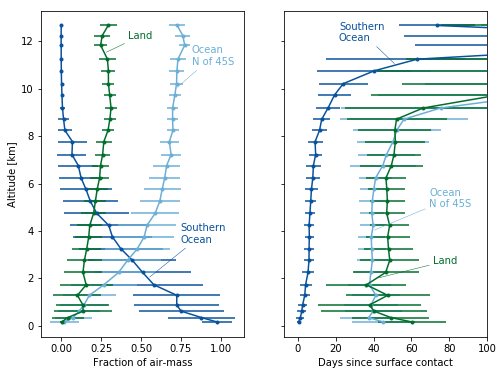

In [66]:
fig = plt.figure(figsize=(8.,6.))

color_so = colorbrewer.singlehue('blue')[1]
color_nh = colorbrewer.singlehue('blue')[4]
color_land = colorbrewer.singlehue('green')[1]
color_age = colorbrewer.singlehue('orange')[1]

ax = fig.add_subplot(121)
sc = ax.errorbar(frac_avg['s_ocn'].values,alt.values,
                 xerr=frac_std['s_ocn'].values,
                 fmt='.-',color=color_so)

sc = ax.errorbar(frac_avg['nh_ocn'].values,alt.values,
                 xerr=frac_std['nh_ocn'].values,
                 fmt='.-',color=color_nh)

sc = ax.errorbar(frac_avg['land'].values,alt.values,
                 xerr=frac_std['land'].values,
                 fmt='.-',color=color_land)


ax.set_ylabel('Altitude [km]')
ax.set_xlabel('Fraction of air-mass')


#-- Label Southern Ocean
y = 2.
x = np.interp(y,alt.values,frac_avg['s_ocn'].values)
ax.annotate('Southern\nOcean', 
            xy=(x,y), 
            xytext=(x+0.2,y+1.5),
            color=color_so,
            arrowprops=dict(color=color_so,arrowstyle='-',linewidth=0.5),
            )

#-- Label NH ocean
y = 10.
x = np.interp(y,alt.values,frac_avg['nh_ocn'].values)
ax.annotate('Ocean\nN of 45S', 
            xy=(x,y), 
            xytext=(x+0.1,y+1),
            color=color_nh,
            arrowprops=dict(color=color_nh,arrowstyle='-',linewidth=0.5),
            )

#-- Label Land
y = 11.5
x = np.interp(y,alt.values,frac_avg['land'].values)
ax.annotate('Land', 
            xy=(x,y), 
            xytext=(x+0.15,y+0.6),
            color=color_land,
            arrowprops=dict(color=color_land,arrowstyle='-',linewidth=0.5),
            )


ax = fig.add_subplot(122)
sc = ax.errorbar(age_avg['s_ocn'].values,alt.values,
                 xerr=age_std['s_ocn'].values,
                 fmt='.-',color=color_so)

sc = ax.errorbar(age_avg['nh_ocn'].values,alt.values,
                 xerr=age_std['nh_ocn'].values,
                 fmt='.-',color=color_nh)

sc = ax.errorbar(age_avg['land'].values,alt.values,
                 xerr=age_std['land'].values,
                 fmt='.-',color=color_land)

ax.set_yticklabels([])
ax.set_xlabel('Days since surface contact')
ax.set_xlim([-7,100])


#-- Label Southern Ocean
y = 11.
x = np.interp(y,alt.values,age_avg['s_ocn'].values)
ax.annotate('Southern\nOcean', 
            xy=(x,y), 
            xytext=(x-30,y+1.),
            color=color_so,
            arrowprops=dict(color=color_so,arrowstyle='-',linewidth=0.5),
            )

#-- Label NH ocean
y = 4.
x = np.interp(y,alt.values,age_avg['nh_ocn'].values)
ax.annotate('Ocean\nN of 45S', 
            xy=(x,y), 
            xytext=(x+30,y+1),
            color=color_nh,
            arrowprops=dict(color=color_nh,arrowstyle='-',linewidth=0.5),
            )

#-- Label Land
y = 2.
x = np.interp(y,alt.values,age_avg['land'].values)
ax.annotate('Land', 
            xy=(x,y), 
            xytext=(x+30,y+0.6),
            color=color_land,
            arrowprops=dict(color=color_land,arrowstyle='-',linewidth=0.5),
            )

plt.savefig(os.path.join(diro['fig'],'vertical-profile-air-provenance-age.png'),
           bbox_inches='tight',dpi=300)